# Problem 1: Implement GDA (QDA)

In [76]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

## Data Proprocessing
Same as in Week 4

```data_cl``` is the dataset of type ```(lon, lat, label)```

In [77]:
# 1. 讀檔
tree = ET.parse("O-A0038-003.xml")
root = tree.getroot()
ns = {"cwa": "urn:cwa:gov:tw:cwacommon:0.1"}

# 2. 取出數字
content_text = root.find(".//cwa:Content", ns).text.strip()
# 將換行取代掉，並處理 -999.0E+00-999.0E+00 的情況
raw_lines = content_text.replace("\n", "").replace("\r", "").replace("-999.0E+00-999.0E+00", "-999.0E+00,-999.0E+00")

# 用逗號分隔
tokens = raw_lines.split(",")
# 補上最後一個
tokens.append(tokens[-1])
# print(len(tokens)) # 檢查用，應該為8040

# 3. 轉成小數，並且把 -999 轉成 NaN
def safe_float(x):
    try:
        val = float(x)
        return np.nan if val == -999 else val
    except ValueError:
        return np.nan

values = np.array([safe_float(x) for x in tokens])

# 4. 重新調整尺寸
grid = values.reshape((120, 67))

# 5. 轉為dataframe
df = pd.DataFrame(grid)

# 6. 建立經緯度坐標
lons = 120.00 + np.arange(67) * 0.03
lats = 21.88 + np.arange(120) * 0.03

# 最左下角是最後一列第一個元素，所以需要把緯度翻轉
lats = lats[::-1]

# 建立經緯度網格
lon_grid, lat_grid = np.meshgrid(lons, lats)

# 分成三個維度的資料
dataset = pd.DataFrame({
    "lon": lon_grid.ravel(),
    "lat": lat_grid.ravel(),
    "temp": grid.ravel()
})

data_cl = dataset[::] # 複製一份資料
data_cl["label"] = data_cl["temp"].apply(lambda x: 0 if pd.isna(x) else 1)
data_cl = data_cl.drop("temp", axis=1)

data_re = dataset[::]
data_re.dropna(subset=["temp"], inplace=True)
data_re = data_re.reset_index(drop=True)

/var/folders/q8/qg42266s5bn3hq7vrzw4nlgc0000gn/T/ipykernel_4715/2337985704.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cl["label"] = data_cl["temp"].apply(lambda x: 0 if pd.isna(x) else 1)
/var/folders/q8/qg42266s5bn3hq7vrzw4nlgc0000gn/T/ipykernel_4715/2337985704.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_re.dropna(subset=["temp"], inplace=True)


## Define class ```GDA```


這裡定義一個 class：

* 首先定義 ```reg``` ，讓我們可以在對角線上加上一個很小的數，預防出現 singular 的矩陣。

* 計算 當 y=0/1 時，資料 X 的平均

* 定義 ```cov``` ，以讓我們計算 y=0/1 時的共變異矩陣，此時我們在對角線上加上一個很小的數預防 singular 矩陣 

* 再分別計算共變異矩陣的反方陣及 $\log(\det(\Sigma))$

* 再定義可以計算等一下要使用的貝氏定理的分母的函數 ```_log_joint```：$\log p(x|y=k)+\log p(y=k)=-\frac{1}{2}((x-\mu)^T\Sigma^{-1}(x-\mu))+\log|\Sigma|+\log p(y=k)+C$

* 定義函數 ```predict_proba``` 以計算給定一個經緯度 (X) 時，預測為 y=1 的機率，算出來的機率定為 ```p1```

* 其中 $p(y=1|x) = \dfrac{p(x|y=1)p(y=1)}{p(x|y=1)p(y=1)+p(x|y=0)p(y=0)}=\dfrac{e^{\log p(x|y=1) + \log p(y=1)}}{e^{\log p(x|y=1) + \log p(y=1)}+e^{\log p(x|y=0) + \log p(y=0)}} := \dfrac{e^{l_1}}{e^{l_1}+e^{l_0}}$，為了避免 $l_1, l_0$ 太大，且 $\dfrac{e^{l_1}}{e^{l_1}+e^{l_0}}=\dfrac{1}{1+e^{l_0-l_1}}$，所以這個機率其實只取決於 $l_0$ 和 $l_1$ 的差，因此這裡定義 $m=\max\{l_0, l_1\}$，讓 $\dfrac{e^{l_1}}{e^{l_1}+e^{l_0}}=\dfrac{e^{l_1-m}}{e^{l_1-m}+e^{l_0-m}}$ ，這樣的話，$l_0, l_1$ 中較大的那個變成 0 ，較小的那個變成負值，數值上更穩定一些

* 最後根據 ```p1``` ，若大於 0.5 ，就判定為 y=1

In [78]:
class GDAQuadratic:
    def __init__(self, reg=1e-6):  # reg: 數值穩定的對角正則化
        self.reg = reg

    def fit(self, X, y):
        y = y.astype(int)
        self.phi = y.mean() # P(Y=1) 就是y的比例
        self.mu0 = X[y==0].mean(axis=0)
        self.mu1 = X[y==1].mean(axis=0)

        def cov(Xc, mu):
            D = Xc - mu
            # MLE：除以 n，而不是 n-1
            S = (D.T @ D) / len(Xc)
            # 數值穩定：Σ ← Σ + reg·I
            return S + self.reg * np.eye(S.shape[0])

        self.S0 = cov(X[y==0], self.mu0)
        self.S1 = cov(X[y==1], self.mu1)
        self.S0_inv, self.S1_inv = np.linalg.inv(self.S0), np.linalg.inv(self.S1)
        self.logdet_S0 = np.log(np.linalg.det(self.S0))
        self.logdet_S1 = np.log(np.linalg.det(self.S1))

    # log p(x|y=k) + log p(y=k)（捨常數項）
    def _log_joint(self, X, mu, Sinv, logdetS, logpy):
        D = X - mu
        # 二次型： (x-μ)^T Σ^{-1} (x-μ)
        quad = np.sum((D @ Sinv) * D, axis=1)
        return -0.5*(quad + logdetS) + logpy

    def predict_proba(self, X):
        logp1 = self._log_joint(X, self.mu1, self.S1_inv, self.logdet_S1, np.log(self.phi))
        logp0 = self._log_joint(X, self.mu0, self.S0_inv, self.logdet_S0, np.log(1 - self.phi))
        
        m = np.maximum(logp0, logp1)
        p1 = np.exp(logp1 - m) / (np.exp(logp0 - m) + np.exp(logp1 - m))
        return p1

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

這裡就將資料送進 ```GDAQuadratic``` 去建立模型

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = data_cl[["lon","lat"]].values
y = data_cl["label"].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

gdaq = GDAQuadratic(reg=1e-5)   # 可微調 reg 提升穩定性
gdaq.fit(Xtr, ytr)
yp = gdaq.predict(Xte)
acc = accuracy_score(yte, yp)
print(f"Test accuracy: {acc:.3f}")

Test accuracy: 0.829


最後畫圖可以發現，我們確實建立了一個二次曲線（橢圓）的邊界

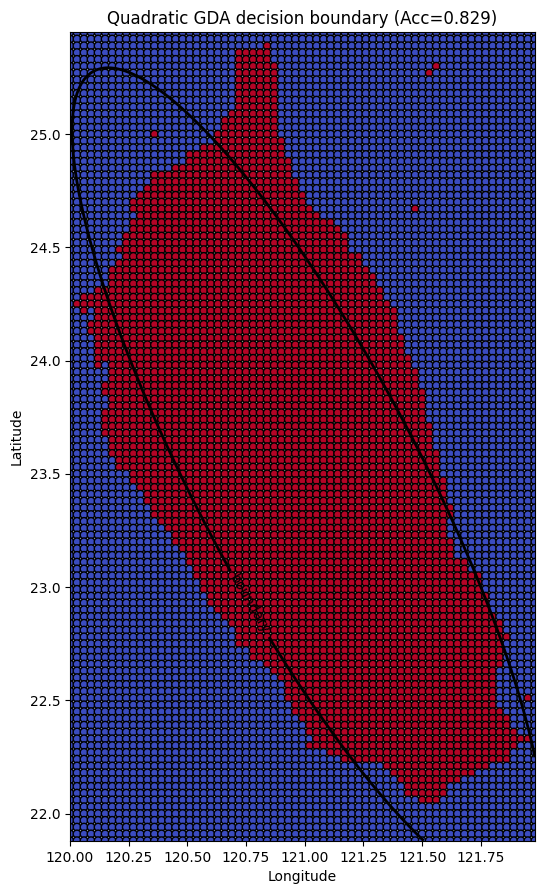

In [80]:
# 建網格
x1 = np.linspace(X[:,0].min(), X[:,0].max(), 400)
x2 = np.linspace(X[:,1].min(), X[:,1].max(), 400)
xx1, xx2 = np.meshgrid(x1, x2)
grid = np.c_[xx1.ravel(), xx2.ravel()]

# 後驗 p(y=1|x)
P1 = gdaq.predict_proba(grid).reshape(xx1.shape)

plt.figure(figsize=(6,10.5))
# 以 0.5 畫決策邊界；同時填背景（0/1）
plt.contourf(xx1, xx2, P1, levels=[0,0.5,1], colors=["#3b82f6","#129609"], alpha=0.25)
CS = plt.contour(xx1, xx2, P1, levels=[0.5], colors="k", linewidths=2)
plt.clabel(CS, fmt={0.5:"boundary"}, inline=True)

# 疊原始資料點
plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", edgecolor="k", s=30)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title(f"Quadratic GDA decision boundary (Acc={acc:.3f})")
plt.show()

# Problem 2: Regression

這裡要將 Week 4 的分類與迴歸部分合而為一，分類上仍採用之前用的邏輯迴歸去做。

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

先看看原始的資料分布：

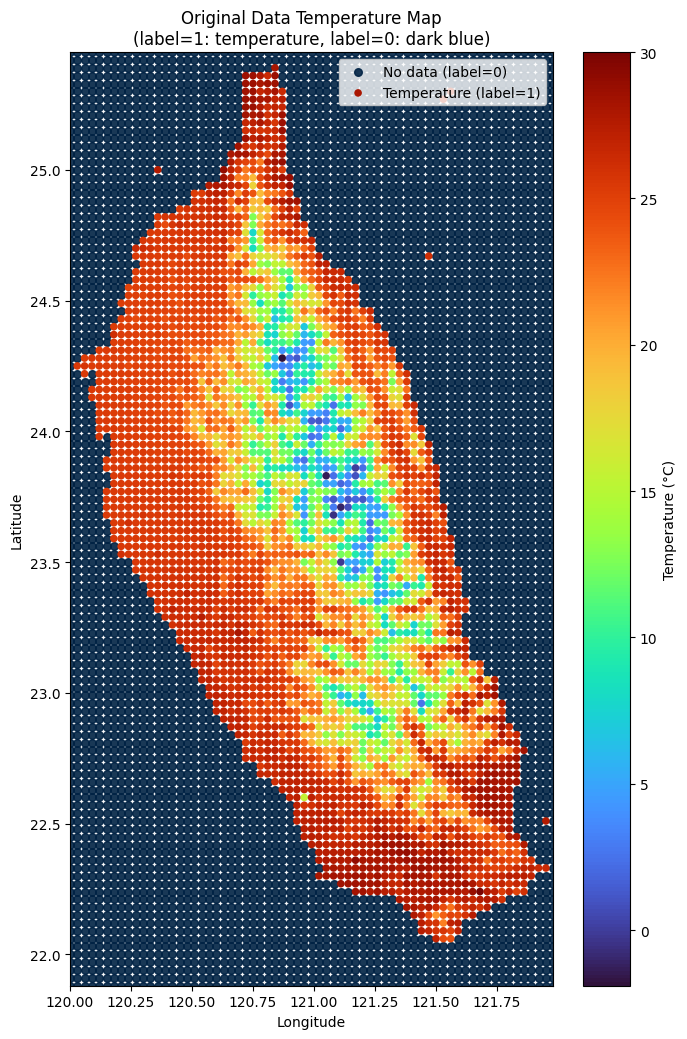

In [82]:
# 整理資料點
# label = 0 的資料點
mask0 = data_cl["label"] == 0
lon0, lat0 = data_cl.loc[mask0, "lon"], data_cl.loc[mask0, "lat"]

# label = 1 的資料點 (應與 data_re 對應)
mask1 = data_cl["label"] == 1
lon1, lat1 = data_cl.loc[mask1, "lon"], data_cl.loc[mask1, "lat"]

# 取出對應的溫度（根據經緯度合併 data_re）
merged = pd.merge(
    data_cl.loc[mask1, ["lon", "lat"]],
    data_re[["lon", "lat", "temp"]],
    on=["lon", "lat"],
    how="left"
)

# 畫圖
plt.figure(figsize=(7,10.5))

# (a) label = 0 的點：深藍色背景
plt.scatter(lon0, lat0, color="#002244", s=30, alpha=0.9, label="No data (label=0)")

# (b) label = 1 的點：依溫度著色
sc = plt.scatter(
    merged["lon"], merged["lat"],
    c=merged["temp"], cmap="turbo", s=30, edgecolor="none",
    label="Temperature (label=1)"
)

# (c) 顏色條
cbar = plt.colorbar(sc)
cbar.set_label("Temperature (°C)")

# (d) 標題與座標軸
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Original Data Temperature Map\n(label=1: temperature, label=0: dark blue)")
plt.legend(loc="upper right")

# (e) 美觀設定
plt.xlim(data_cl["lon"].min(), data_cl["lon"].max())
plt.ylim(data_cl["lat"].min(), data_cl["lat"].max())
plt.tight_layout()
plt.show()


將 Week 4 的訓練模型過程偷過來

In [83]:
X = data_cl[["lon", "lat"]]   # 特徵
y = data_cl["label"]          # 標籤

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=114514, stratify=y)
# stratify=y 讓劃分時，訓練集和測試集中的0/1比率盡量和原始資料相同

poly_log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=5, include_bias=False)),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

poly_log_reg.fit(X_train, y_train)

# print("訓練集準確率:", poly_log_reg.score(X_train, y_train))
# print("測試集準確率:", poly_log_reg.score(X_test, y_test))

X = data_re[["lon", "lat"]]
y = data_re["temp"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=114514)
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

主要靠以下的 ```predict_many``` 函數來做預測，首先把全部輸入的經緯度點的溫度設為 -999，再把輸入中 label = 1 （也就是有溫度資料）的經緯度點全部送進預測，以生成預測出的溫度。這樣一來 label = 1 的點就有了用迴歸模型預測出的溫度，而 label = 0 的點就仍然保持 -999 的值。

In [84]:
def predict_many(df_coords, clf_model, reg_model):

    preds_label = clf_model.predict(df_coords)
    preds_temp = np.full(len(df_coords), -999.0)  # 先全設為 -999

    idx_valid = np.where(preds_label == 1)[0]
    if len(idx_valid) > 0:
        preds_temp[idx_valid] = reg_model.predict(df_coords.iloc[idx_valid])

    result = df_coords.copy()
    result["label_pred"] = preds_label
    result["temp_pred"] = preds_temp
    return result

這裡將所有的點都丟進去預測，再生出圖來：

In [85]:
test_points = pd.DataFrame({'lon': dataset["lon"], 'lat': dataset["lat"]})

results = predict_many(test_points, poly_log_reg, rf_reg)
print(results)

         lon    lat  label_pred  temp_pred
0     120.00  25.45           0     -999.0
1     120.03  25.45           0     -999.0
2     120.06  25.45           0     -999.0
3     120.09  25.45           0     -999.0
4     120.12  25.45           0     -999.0
...      ...    ...         ...        ...
8035  121.86  21.88           0     -999.0
8036  121.89  21.88           0     -999.0
8037  121.92  21.88           0     -999.0
8038  121.95  21.88           0     -999.0
8039  121.98  21.88           0     -999.0

[8040 rows x 4 columns]


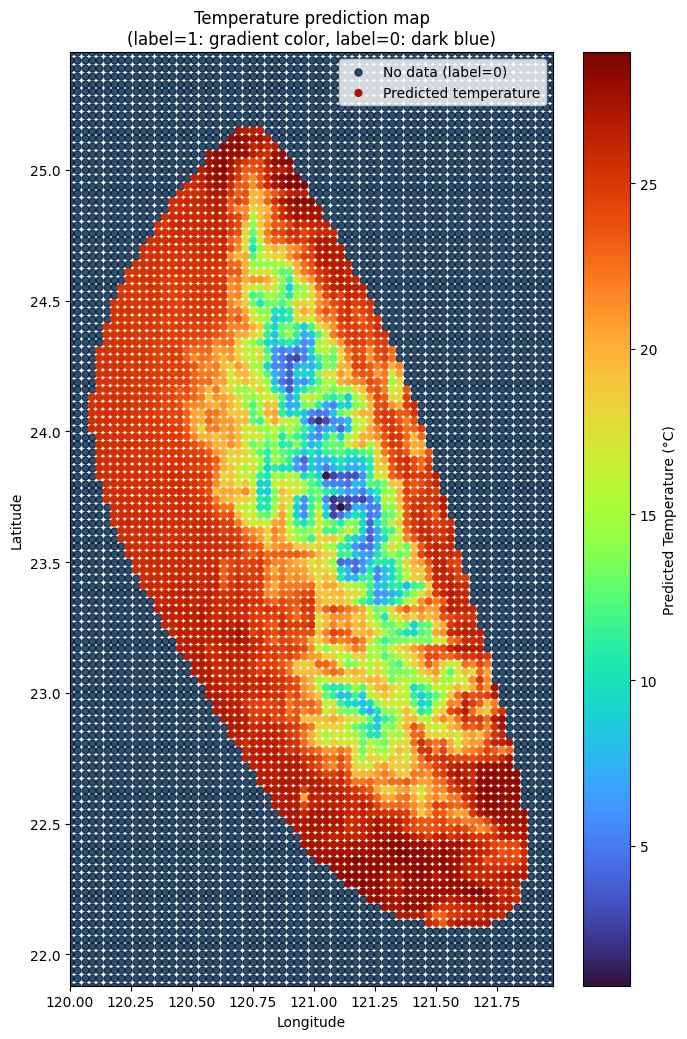

In [86]:
# === 1. 生成圖上要顯示的點 ===
# 這裡的 results 來自你的 predict_many()

lon_min, lon_max = results["lon"].min(), results["lon"].max()
lat_min, lat_max = results["lat"].min(), results["lat"].max()

# === 2. 分類：1有溫度、0無溫度 ===
mask_valid = results["label_pred"] == 1
mask_invalid = results["label_pred"] == 0

# === 4. 開始畫圖 ===
plt.figure(figsize=(7,10.5))

# (a) 背景：label=0 的位置（深藍色）
plt.scatter(
    results.loc[mask_invalid, "lon"],
    results.loc[mask_invalid, "lat"],
    c="#002244", s=25, alpha=0.8, label="No data (label=0)"
)

# (b) label=1 的點，以溫度漸層顏色顯示
sc = plt.scatter(
    results.loc[mask_valid, "lon"],
    results.loc[mask_valid, "lat"],
    c=results.loc[mask_valid, "temp_pred"],
    cmap="turbo", s=35, edgecolor="none", label="Predicted temperature"
)

# === 5. 美化圖面 ===
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Temperature prediction map\n(label=1: gradient color, label=0: dark blue)")
plt.legend(loc="upper right")

# 顏色條（對應溫度）
cbar = plt.colorbar(sc)
cbar.set_label("Predicted Temperature (°C)")

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
plt.tight_layout()
plt.show()


將兩圖放在一起比較（左：原始資料 / 右：預測結果）

/var/folders/q8/qg42266s5bn3hq7vrzw4nlgc0000gn/T/ipykernel_4715/993055649.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


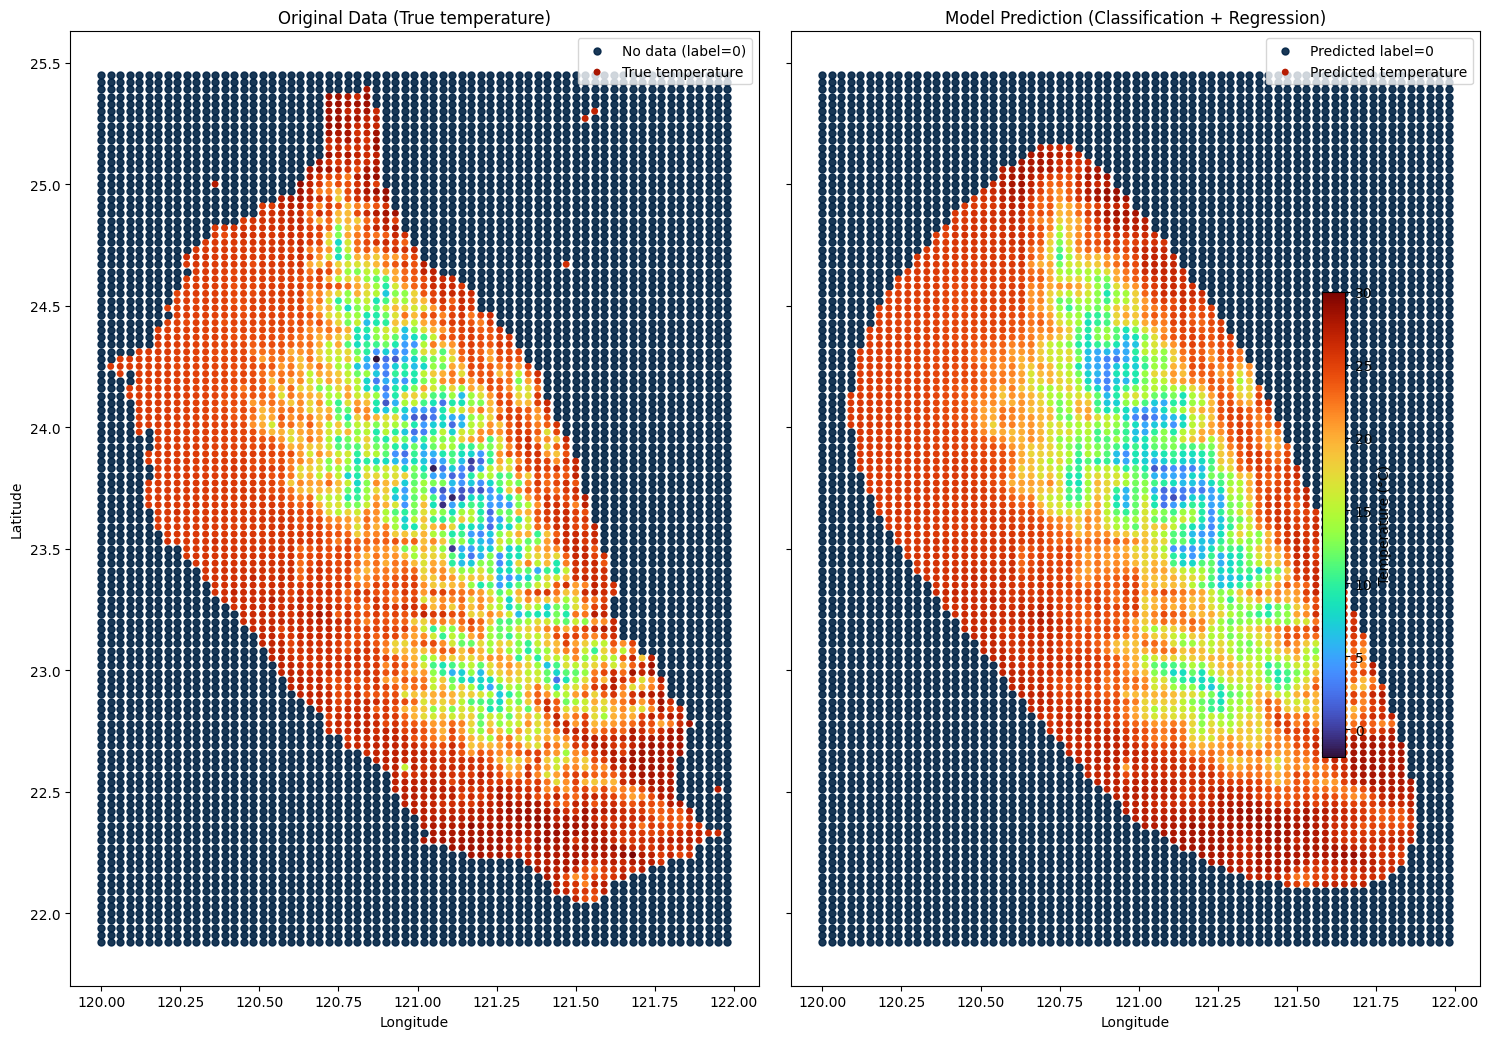

In [96]:
model_pred = predict_many(test_points, poly_log_reg, rf_reg)

# 設定顏色範圍（確保兩圖一致）
vmin = min(merged["temp"].min(), model_pred.loc[model_pred["label_pred"]==1, "temp_pred"].min())
vmax = max(merged["temp"].max(), model_pred.loc[model_pred["label_pred"]==1, "temp_pred"].max())

fig, ax = plt.subplots(1, 2, figsize=(15,10.5), sharey=True)

# ===== 左圖：真實溫度 =====
ax[0].scatter(
    data_cl.loc[mask0, "lon"],
    data_cl.loc[mask0, "lat"],
    color="#002244", s=25, alpha=0.9, label="No data (label=0)"
)
sc1 = ax[0].scatter(
    merged["lon"], merged["lat"],
    c=merged["temp"], cmap="turbo", s=25, edgecolor="none",
    vmin=vmin, vmax=vmax, label="True temperature"
)
ax[0].set_title("Original Data (True temperature)")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
ax[0].legend()

# ===== 右圖：模型預測結果 =====
mask_pred0 = model_pred["label_pred"] == 0
mask_pred1 = model_pred["label_pred"] == 1

ax[1].scatter(
    model_pred.loc[mask_pred0, "lon"],
    model_pred.loc[mask_pred0, "lat"],
    color="#002244", s=25, alpha=0.9, label="Predicted label=0"
)
# 用 c=... 畫出漸層
sc2 = ax[1].scatter(
    model_pred.loc[mask_pred1, "lon"],
    model_pred.loc[mask_pred1, "lat"],
    c=model_pred.loc[mask_pred1, "temp_pred"], cmap="turbo",
    s=25, edgecolor="none", vmin=vmin, vmax=vmax,
    label="Predicted temperature"
)
ax[1].set_title("Model Prediction (Classification + Regression)")
ax[1].set_xlabel("Longitude")
ax[1].legend()

# ===== 共用 colorbar（綁定右圖的 scatter） =====

cbar = fig.colorbar(sc2, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label("Temperature (°C)")




plt.tight_layout()
plt.show()


最後，我們隨機生成一些經緯度點來做分類與迴歸

In [88]:
def generate_and_predict(n_points, lon_range, lat_range, clf_model, reg_model):
    rng = np.random.default_rng()
    # 生成隨機的經緯度點
    random_points = pd.DataFrame({
        "lon": rng.uniform(lon_range[0], lon_range[1], n_points),
        "lat": rng.uniform(lat_range[0], lat_range[1], n_points)
    })

    # 先分0/1
    label_pred = clf_model.predict(random_points)

    # 全設為-999
    temp_pred = np.full(n_points, -999.0)

    # 只對y=1的點預測
    idx_valid = np.where(label_pred == 1)[0]
    if len(idx_valid) > 0:
        temp_pred[idx_valid] = reg_model.predict(random_points.iloc[idx_valid])

    # 拼成df
    result = random_points.copy()
    result["label_pred"] = label_pred
    result["temp_pred"] = temp_pred
    return result

lon_min, lon_max = data_cl["lon"].min(), data_cl["lon"].max()
lat_min, lat_max = data_cl["lat"].min(), data_cl["lat"].max()

rand_results = generate_and_predict(
    n_points=100,
    lon_range=(lon_min, lon_max),
    lat_range=(lat_min, lat_max),
    clf_model=poly_log_reg,
    reg_model=rf_reg
)

print(rand_results.head())

          lon        lat  label_pred  temp_pred
0  120.446243  21.914076           0  -999.0000
1  121.442266  24.240738           0  -999.0000
2  120.280914  24.789176           0  -999.0000
3  120.380900  24.203443           1    24.7535
4  120.320814  25.002059           0  -999.0000
